# Hands On #10 - Balancing the Cart Pole w/ Policy Gradient (REINFORCE)

## Goal:
* Implement Policy Gradient Network for CartPole
    * It is a lot simpler !!

## Steps:
1. Program REINFORCE
2. Plot Values

Reference : 
* My solution for the DQN https://github.com/xsankar/DQN_Navigation/blob/master/Navigation-v2.ipynb
* Udacity https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb

## Notebook Organization:

### The notebook has 3 parts :

* __Part 1__ : Defines the classes, initiates the environment and so forth. It sets up all the scaffolding needed
* __Part 2__ : Explore and Learn - it performs the REINFORCE Reinforcement Learning. It also saves the best model
* __Part 3__ : Run saved model or the learned model

## Part 1 - Definitions & Setup
----

### 1. Install the required packages
* No esoteric requirements
* You can run them without docker
* pip install -r requirements.txt
* Requirements
 * python 3.6, pytorch, openAI gym, numpy, matplotlib
 * anaconda is easier but not needed
 * Miniconda works fine

### 2. Define imports

python 3, numpy, matplotlib, torch, gym

In [1]:
# General imports
import gym
# import PIL # for in-line display of certain environments

import sys
import numpy as np
import random
from collections import namedtuple, deque, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2.1. Global Constants and other variables

In [2]:
# Constants Definitions
BUFFER_SIZE = 512 # int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
# Number of neurons in the layers of the Q Network
FC1_UNITS = 16
FC2_UNITS = 8
FC3_UNITS = 4
# Store models flag. Store during calibration runs and do not store during hyperparameter search
STORE_MODELS = False

### Work Area

In [3]:
# Work area to quickly test utility functions
import math
import time
from datetime import datetime, timedelta
'''
start_time = time.time()
time.sleep(10)
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
'''
print(math.radians(12))
print(math.radians(-12))

0.20943951023931956
-0.20943951023931956


In [4]:
'''import gym, PIL
env = gym.make('CartPole-v0')
array = env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))
'''

"import gym, PIL\nenv = gym.make('CartPole-v0')\narray = env.reset()\nPIL.Image.fromarray(env.render(mode='rgb_array'))\n"

### 3.0 Create instance & Explore

In [5]:
import gym
env = gym.make('CartPole-v0')
env.seed(42)
# array = env.reset()
env.reset()
env.render()
#PIL.Image.fromarray(env.render(mode='rgb_array'))

/miniconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


True

### 3.1 Examine the State and Action Spaces

* The state space is continuous, with an observation space of 4 
    * {x,$\dot{x}$,$\theta$, theta_dot}
        * Cart Position,  Cart Velocity, Pole Angle, Pole Velocity at tip
        * The angle, probably, is in radians

The action space, on the contrary is simple viz. 0 = Left, 1 = Right

In [6]:
print(env.observation_space)
print(env.action_space)
act_space = [i for i in range(0,env.action_space.n)]
print(act_space)
# env.unwrapped.get_action_meanings() # AttributeError: 'FrozenLakeEnv' object has no attribute 'get_action_meanings'
print('[ 0 = Left, 1 = Right ]')

Box(4,)
Discrete(2)
[0, 1]
[ 0 = Left, 1 = Right ]


In [7]:
print(dir(env))
print(dir(env.unwrapped))
# To see what functions and variables are availabe
print('States = ',env.unwrapped.observation_space)
print('Actions = ',env.unwrapped.action_space)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_elapsed_seconds', '_elapsed_steps', '_episode_started_at', '_max_episode_seconds', '_max_episode_steps', '_past_limit', 'action_space', 'class_name', 'close', 'compute_reward', 'env', 'metadata', 'observation_space', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_pole_geom', 'acti

In [8]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### 4. Test the environment with Random Action

In [9]:
for i_episode in range(3):
    state = env.reset()
    tot_reward = 0
    steps = 0
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        print('[',state,']','->', action,' : [',next_state,']', 'R=',reward)
        # env.render()
        tot_reward += reward
        steps += 1
        if done:
            print('Episode {:d} finished after {:d} steps with a Total Reward = {:.0f}'.format(i_episode+1,steps, tot_reward))
            break
        else:
            state = next_state
# Pole angle +/-12 degrees, Cart Pos +/- 2.4 or 200 steps
# Cart Pos, Velocity, Pole Angle, Velocity
# 12 degrees = .2094 radians

[ [ 0.00560942  0.01842265 -0.03590751 -0.0120678 ] ] -> 0  : [ [ 0.00597787 -0.17616644 -0.03614886  0.26907314] ] R= 1.0
[ [ 0.00597787 -0.17616644 -0.03614886  0.26907314] ] -> 1  : [ [ 0.00245454  0.01945224 -0.0307674  -0.03478864] ] R= 1.0
[ [ 0.00245454  0.01945224 -0.0307674  -0.03478864] ] -> 1  : [ [ 0.00284359  0.21500159 -0.03146317 -0.33701802] ] R= 1.0
[ [ 0.00284359  0.21500159 -0.03146317 -0.33701802] ] -> 0  : [ [ 0.00714362  0.02034118 -0.03820353 -0.05442056] ] R= 1.0
[ [ 0.00714362  0.02034118 -0.03820353 -0.05442056] ] -> 1  : [ [ 0.00755044  0.2159895  -0.03929194 -0.35890801] ] R= 1.0
[ [ 0.00755044  0.2159895  -0.03929194 -0.35890801] ] -> 1  : [ [ 0.01187023  0.41164734 -0.0464701  -0.66371712] ] R= 1.0
[ [ 0.01187023  0.41164734 -0.0464701  -0.66371712] ] -> 1  : [ [ 0.02010318  0.60738391 -0.05974445 -0.97066231] ] R= 1.0
[ [ 0.02010318  0.60738391 -0.05974445 -0.97066231] ] -> 1  : [ [ 0.03225086  0.80325467 -0.07915769 -1.28149866] ] R= 1.0
[ [ 0.03225086  

## The Algorithm

## REINFORCE Policy Gradient
### Let us implement a simple Policy Gradient Algorithm
<img src='REINFORCE_Alg.png'>

The basic algorithm is very simple:
1. `Policy Network` - implemented as a Deep Neural Network whih consists of fully connected layers.
2. `REINFORCE Algorithm` - orchastrates the environment and the policy. It interacts with the environment by taking actions based on a policy, collects rewards and the observation feedback and also initiates a learning step on the Policy Network.

In [10]:
# See if we can run in GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
class Policy(nn.Module):
    def __init__(self, state_size=state_size, action_size=action_size, seed = 42, fc1_units = FC1_UNITS, fc2_units = FC2_UNITS, 
                 fc3_units = FC3_UNITS):
        super(Policy, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### REINFORCE Algorithm

Once we have defined the foundations (network, the algorithm and so forth), the actual is relatively easy. It has a few responsibilities:
1. Orchastrate the episodes calling the appropriate methods
2. Display a running commentry of the scores and episode count
3. Check the success criterion for solving the environment i.e. if running average is > 195.0 and print the episode count
4. Store the model with the maximum score
5. Keep track of the scores for analytics at the end of the run

In [14]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        while True:
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

## Part 2 - Learn & Train
-----

### The actual training Run

1. Run the Policy Network implemented using the REINFORCE Algorithm
2. Calculate and display end-of-run analytics viz. descriptive statistics and a plot of the scores

Episode 100	Average Score: 47.22
Episode 200	Average Score: 80.94
Episode 300	Average Score: 116.19
Episode 400	Average Score: 112.00
Episode 500	Average Score: 191.65
Environment solved in 450 episodes!	Average Score: 195.18
Elapsed : 0:00:23.645272
2019-01-12 11:47:30.619834


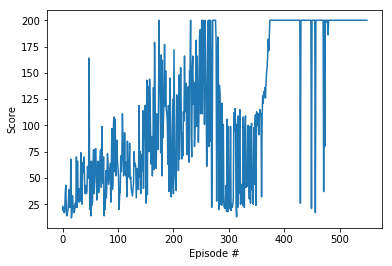

Max Score 200.000000 at 174
Percentile [25,50,75] : [ 51. 111. 200.]
Variance : 4779.687


In [15]:
start_time = time.time()
scores = reinforce(n_episodes=5000) 
env.close() # Close the environment
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print('Max Score {:2f} at {}'.format(np.max(scores), np.argmax(scores)))
print('Percentile [25,50,75] : {}'.format(np.percentile(scores,[25,50,75])))
print('Variance : {:.3f}'.format(np.var(scores)))

### A Good run

<img src="reinforce_run.png">

## Part 3 : Test - Run a stored Model or test the current model

### Note
Here we are saving and loading the state dict, because we have access to the code.

- `torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')`
- `agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

The best way to save and load model, to be used by 2 distinct and separate entities is to :
- `torch.save(model, filepath)`; 
- Then later, `model = torch.load(filepath)`

In [26]:
# agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

### Points to Ponder
1. While the algorithm is simple, it is at the mercy of random numbers !
    * Sometimes it meanders around without solving the environment
2. I have captures one run that did solve the environment
3. Try various tweaks and learn

## Test our Policy Network

In [16]:
scores=[]
for i in range(100): # 10 episodes
    state = env.reset()                                   # reset the environment
    score = 0                                             # initialize the score
    while True:
        action, _ = policy.act(state)                         # select an action
        next_state, reward, done, info = env.step(action) # send the action to the environment
        score += reward                                   # update the score
        state = next_state                                # roll over the state to next time step
        if done:                                          # exit loop if episode finished
            break
    scores.append(score)
    print("Episode {:2d} Score {:5.2f}".format(i+1,score))
print('Mean of {} episodes = {}'.format(i+1,np.mean(scores)))
print(datetime.now())
env.close()

Episode  1 Score 200.00
Episode  2 Score 200.00
Episode  3 Score 200.00
Episode  4 Score 200.00
Episode  5 Score 200.00
Episode  6 Score 200.00
Episode  7 Score 200.00
Episode  8 Score 200.00
Episode  9 Score 200.00
Episode 10 Score 200.00
Episode 11 Score 200.00
Episode 12 Score 200.00
Episode 13 Score 200.00
Episode 14 Score 200.00
Episode 15 Score 200.00
Episode 16 Score 200.00
Episode 17 Score 200.00
Episode 18 Score 200.00
Episode 19 Score 200.00
Episode 20 Score 200.00
Episode 21 Score 200.00
Episode 22 Score 200.00
Episode 23 Score 200.00
Episode 24 Score 200.00
Episode 25 Score 200.00
Episode 26 Score 200.00
Episode 27 Score 200.00
Episode 28 Score 200.00
Episode 29 Score 200.00
Episode 30 Score 200.00
Episode 31 Score 200.00
Episode 32 Score 200.00
Episode 33 Score 200.00
Episode 34 Score 200.00
Episode 35 Score 200.00
Episode 36 Score 200.00
Episode 37 Score 200.00
Episode 38 Score 200.00
Episode 39 Score 200.00
Episode 40 Score 200.00
Episode 41 Score 200.00
Episode 42 Score

In [18]:
env.close()